<a href="https://colab.research.google.com/github/SARIKELLA-MADHU/Machine-Learning/blob/main/week_7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs, make_moons
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN, Birch, SpectralClustering
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.neighbors import NearestNeighbors
from scipy.spatial.distance import pdist, squareform
from sklearn.metrics import pairwise_distances
import math

# -----------------------------
# 1) Distance / Similarity functions
# -----------------------------
def euclidean_distance(a, b):
    a = np.asarray(a); b = np.asarray(b)
    return np.sqrt(np.sum((a - b) ** 2))

def manhattan_distance(a, b):
    a = np.asarray(a); b = np.asarray(b)
    return np.sum(np.abs(a - b))

def minkowski_distance(a, b, p=3):
    a = np.asarray(a); b = np.asarray(b)
    return np.power(np.sum(np.abs(a - b) ** p), 1.0/p)

def cosine_similarity(a, b):
    a = np.asarray(a); b = np.asarray(b)
    denom = (np.linalg.norm(a) * np.linalg.norm(b))
    if denom == 0:
        return 0.0
    return np.dot(a, b) / denom

def jaccard_index(a, b):
    # expects binary vectors (0/1). If not binary, threshold at >0
    a = np.asarray(a) > 0
    b = np.asarray(b) > 0
    inter = np.logical_and(a, b).sum()
    union = np.logical_or(a, b).sum()
    if union == 0:
        return 1.0 if inter == 0 else 0.0
    return inter / union

# Quick sanity checks
pt1 = [2,3]; pt2 = [5,7]
print("Euclidean:", euclidean_distance(pt1, pt2))
print("Manhattan:", manhattan_distance(pt1, pt2))
print("Minkowski (p=3):", minkowski_distance(pt1, pt2, p=3))
print("Cosine similarity:", cosine_similarity(pt1, pt2))
print("Jaccard (binary) [1,1,0] vs [1,0,1]:", jaccard_index([1,1,0],[1,0,1]))


Euclidean: 5.0
Manhattan: 7
Minkowski (p=3): 4.497941445275415
Cosine similarity: 0.9994801143396996
Jaccard (binary) [1,1,0] vs [1,0,1]: 0.3333333333333333


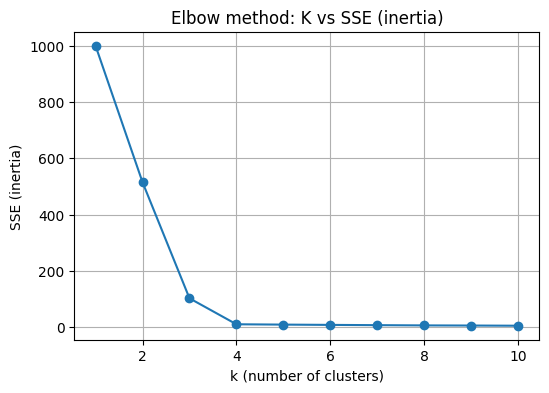

In [2]:
X_blob, y_blob = make_blobs(n_samples=500, centers=4, cluster_std=0.60, random_state=42)
X_moons, y_moons = make_moons(n_samples=400, noise=0.07, random_state=42)  # non-linear shapes (for DBSCAN / spectral)
scaler = StandardScaler()
X_blob_scaled = scaler.fit_transform(X_blob)
X_moons_scaled = scaler.fit_transform(X_moons)

# -----------------------------
# 3) K-Means + Elbow method (SSE/inertia)
# -----------------------------
sse = []
ks = list(range(1,11))
for k in ks:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    km.fit(X_blob_scaled)
    sse.append(km.inertia_)

plt.figure(figsize=(6,4))
plt.plot(ks, sse, marker='o')
plt.title("Elbow method: K vs SSE (inertia)")
plt.xlabel("k (number of clusters)")
plt.ylabel("SSE (inertia)")
plt.grid(True)
plt.show()

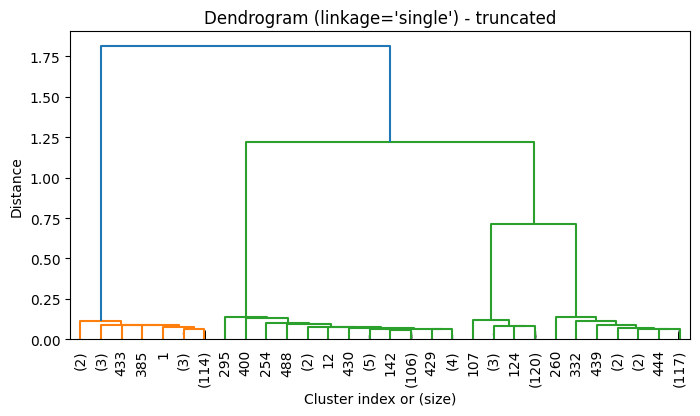

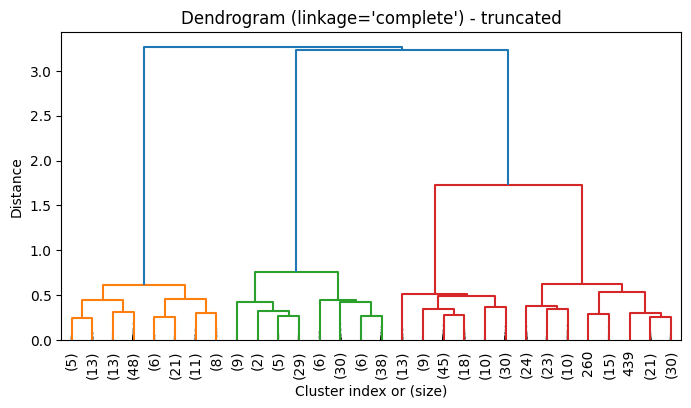

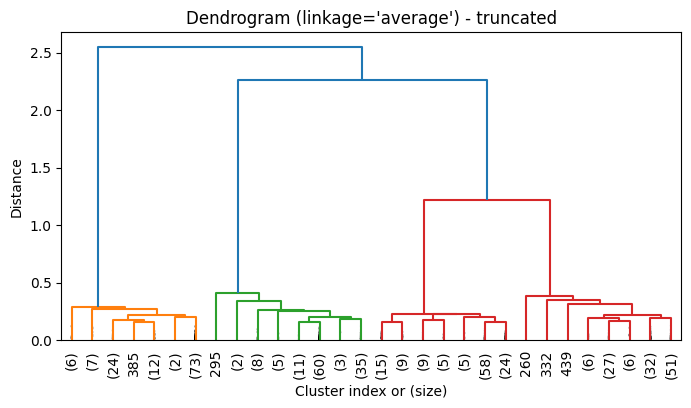

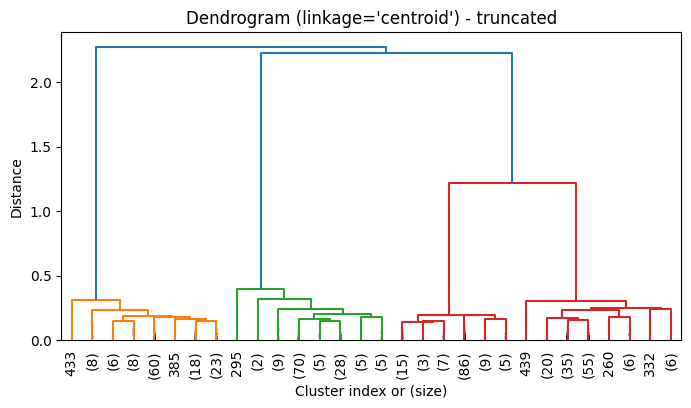

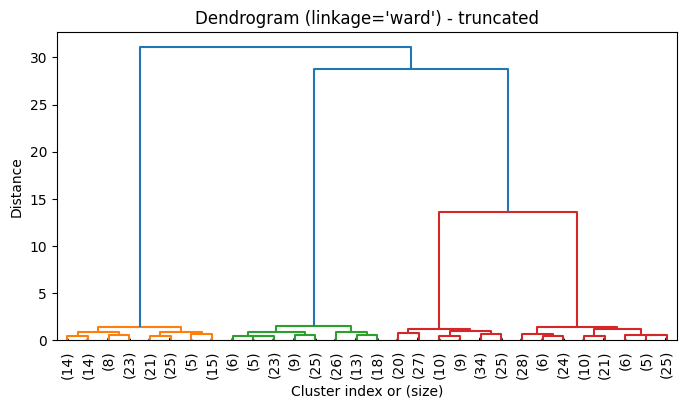

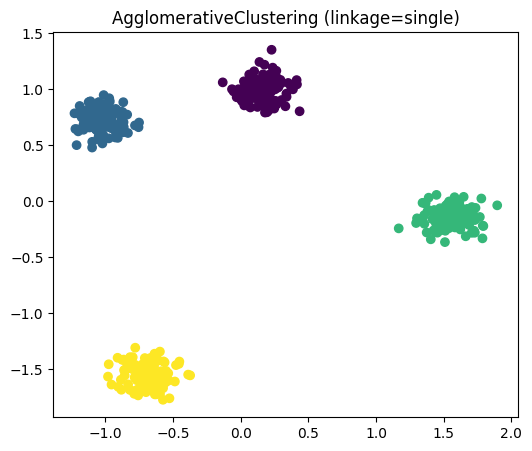

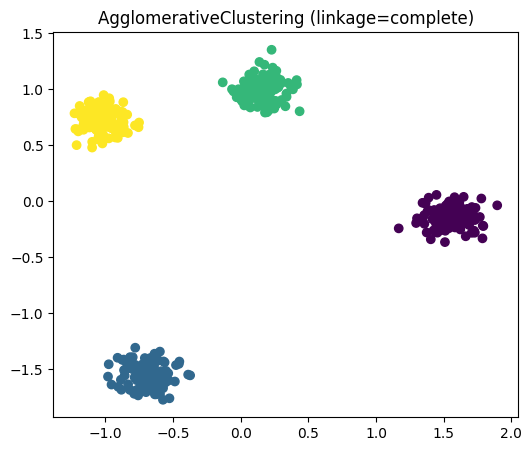

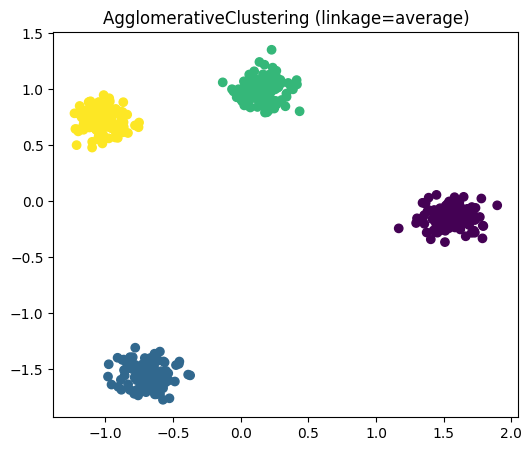

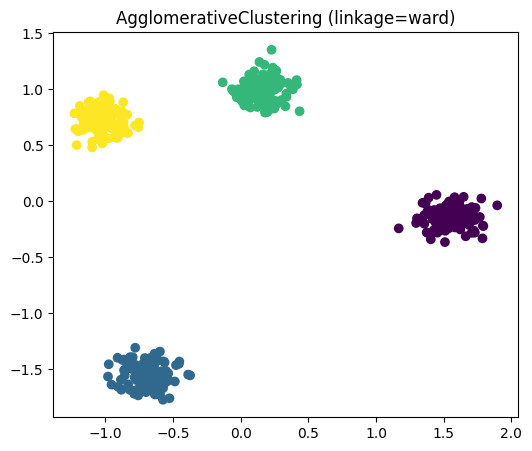

In [3]:
methods = ['single', 'complete', 'average', 'centroid', 'ward']
for method in methods:
    Z = linkage(X_blob_scaled, method=method) if method != 'ward' else linkage(X_blob_scaled, method='ward')
    plt.figure(figsize=(8, 4))
    dendrogram(Z, truncate_mode='lastp', p=30, leaf_rotation=90., leaf_font_size=10., show_contracted=True)
    plt.title(f"Dendrogram (linkage='{method}') - truncated")
    plt.xlabel("Cluster index or (size)")
    plt.ylabel("Distance")
    plt.show()

# Show agglomerative clustering labels for a few linkages
for linkage_method in ['single', 'complete', 'average', 'ward']:
    agg = AgglomerativeClustering(n_clusters=4, linkage=linkage_method)
    lbl = agg.fit_predict(X_blob_scaled)
    plt.figure(figsize=(6,5))
    plt.scatter(X_blob_scaled[:,0], X_blob_scaled[:,1], c=lbl)
    plt.title(f"AgglomerativeClustering (linkage={linkage_method})")
    plt.show()


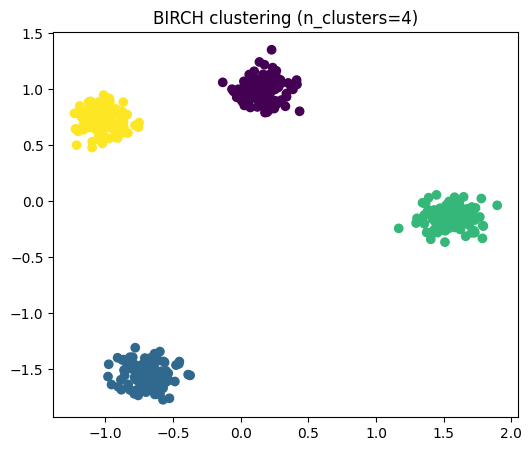

In [4]:
br = Birch(n_clusters=4)
labels_birch = br.fit_predict(X_blob_scaled)
plt.figure(figsize=(6,5))
plt.scatter(X_blob_scaled[:,0], X_blob_scaled[:,1], c=labels_birch)
plt.title("BIRCH clustering (n_clusters=4)")
plt.show()


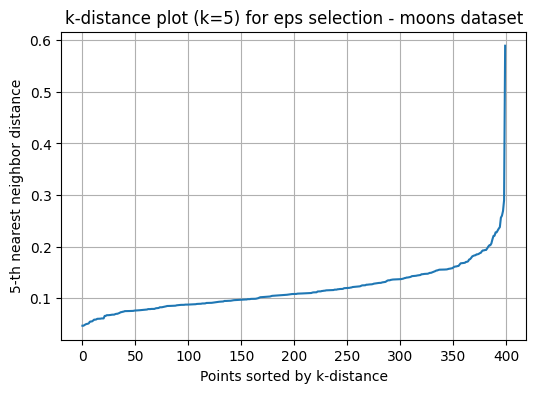

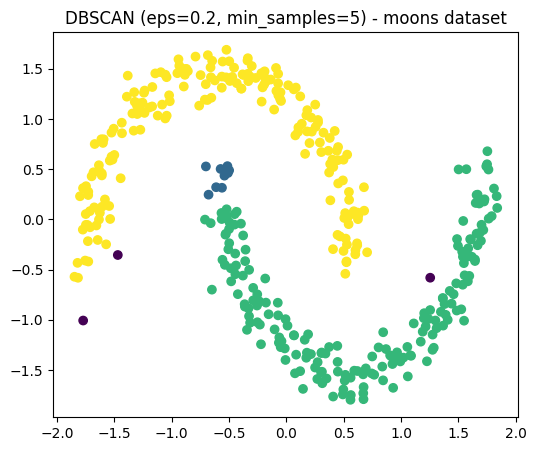

DBSCAN: number of clusters (excluding noise): 3 noise points: 3


In [6]:
min_samples = 5
nbrs = NearestNeighbors(n_neighbors=min_samples).fit(X_moons_scaled)
distances, indices = nbrs.kneighbors(X_moons_scaled)
k_distances = np.sort(distances[:, -1])

plt.figure(figsize=(6,4))
plt.plot(np.arange(len(k_distances)), k_distances)
plt.title(f"k-distance plot (k={min_samples}) for eps selection - moons dataset")
plt.xlabel("Points sorted by k-distance")
plt.ylabel(f"{min_samples}-th nearest neighbor distance")
plt.grid(True)
plt.show()

eps_choice = 0.2
db = DBSCAN(eps=eps_choice, min_samples=min_samples)
labels_db = db.fit_predict(X_moons_scaled)
plt.figure(figsize=(6,5))
plt.scatter(X_moons_scaled[:,0], X_moons_scaled[:,1], c=labels_db)
plt.title(f"DBSCAN (eps={eps_choice}, min_samples={min_samples}) - moons dataset")
plt.show()
print("DBSCAN: number of clusters (excluding noise):", len(set(labels_db)) - (1 if -1 in labels_db else 0),
      "noise points:", list(labels_db).count(-1))

/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


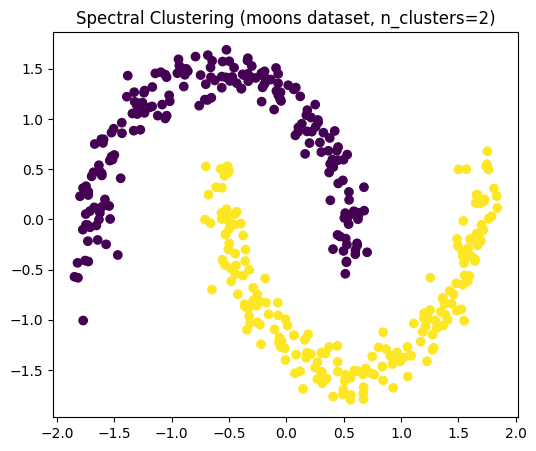

Binary matrix:\n [[1 0 1 0]
 [1 1 0 0]
 [0 1 1 0]
 [1 0 0 1]]
Jaccard similarity matrix:\n [[1.    0.333 0.333 0.333]
 [0.333 1.    0.333 0.333]
 [0.333 0.333 1.    0.   ]
 [0.333 0.333 0.    1.   ]]
\nDemo complete. Adjust parameters or replace datasets with your own data for real experiments.


In [7]:
sc = SpectralClustering(n_clusters=2, affinity='nearest_neighbors', n_neighbors=10, random_state=42)
labels_spec = sc.fit_predict(X_moons_scaled)
plt.figure(figsize=(6,5))
plt.scatter(X_moons_scaled[:,0], X_moons_scaled[:,1], c=labels_spec)
plt.title("Spectral Clustering (moons dataset, n_clusters=2)")
plt.show()

# -----------------------------
# 9) Jaccard similarity matrix demo for small binary matrix
# -----------------------------
bin_mat = np.array([[1,0,1,0],[1,1,0,0],[0,1,1,0],[1,0,0,1]])
n = bin_mat.shape[0]
jaccard_mat = np.zeros((n,n))
for i in range(n):
    for j in range(n):
        jaccard_mat[i,j] = jaccard_index(bin_mat[i], bin_mat[j])
print("Binary matrix:\\n", bin_mat)
print("Jaccard similarity matrix:\\n", np.round(jaccard_mat,3))

print("\\nDemo complete. Adjust parameters or replace datasets with your own data for real experiments.")
